In [1]:
# The GPU id to use, either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [2]:
# !conda create --name steffen-voxelmorph-python3.7_tf2.4.1 python=3.7 tensorflow-gpu=2.4.1 ipykernel ipywidgets notebook jupyter
# !conda activate steffen-voxelmorph-python3.7_tf2.4.1
# !pip install voxelmorph  # for all things voxelmorph/neurite
# !pip install tensorflow_addons  # for tqdm callbacks


In [3]:
# screen
# conda activate steffen-voxelmorph-python3.7_tf2.4.1
# conda install runipy
# runipy brain3D_ourdata.ipynb
# or
# jupyter nbconvert --to notebook --execute brain3D_ourdata.ipynb --output executed.ipynb

In [4]:
# some imports we'll need throughout the demo
import os

# some third party very useful libraries
import tensorflow as tf
import tensorflow_addons as tfa  # for TQDM callback
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import nibabel as nib

# our libraries
import voxelmorph as vxm
import neurite as ne

# turn off eager for this
# need to do it due to some tf 2.0+ compatibility issues
tf.compat.v1.disable_eager_execution()

# some helpful functions
def plot_hist(hist):
  plt.figure(figsize=(17,5))
  plt.subplot(1, 2, 1)
  plt.plot(hist.epoch, hist.history['loss'], '.-')
  plt.ylabel('loss')
  plt.xlabel('epochs');
  plt.subplot(1, 2, 2)
  nb_epochs = len(hist.epoch) // 2
  plt.plot(hist.epoch[-nb_epochs:], hist.history['loss'][-nb_epochs:], '.-')
  plt.ylabel('loss')
  plt.xlabel('epochs');
  plt.show()


# generally useful callback
# unfortunately show_epoch_progress=True leaves a printout that we can't control (bad implementation in tfa...)
tqdm_cb = tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False, show_epoch_progress=False) 

2021-09-26 23:01:08.084681: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [7]:
# prepare data
# !ln -s /mnt/FileSystem-DeepLearning/vnm/qsm28_data/realigned_bias-corrected_skullstripped_rescaled-0-1 ourdata
files = ['ourdata/' + f for f in os.listdir('ourdata') if f.endswith('interp.nii.gz')]
vols = [nib.load(f).get_fdata() for f in tqdm(files)]

  0%|          | 0/59 [00:00<?, ?it/s]

x_vols_full.shape:  (59, 66, 61, 47, 1)
x_vols.shape:  (59, 66, 61, 47, 1)


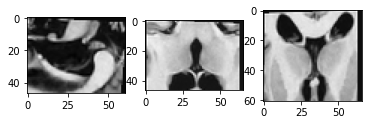

In [9]:
x_vols_full = np.expand_dims(np.stack(vols, 0), -1)
print('x_vols_full.shape: ', x_vols_full.shape)
x_vols = x_vols_full[:,0:192,0:192,0:192]
print('x_vols.shape: ', x_vols.shape)
vol_shape = x_vols.shape[1:-1]


# visualize input data
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(x_vols[2,30,:,:], -1), cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(x_vols[2,:,30,:], -1), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(x_vols[2,:,:,30], -1), cmap='gray')

In [ ]:
# get the model
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]
model = vxm.networks.TemplateCreation(vol_shape, nb_unet_features=[enc_nf, dec_nf])

In [ ]:
# prepare a simple generator. 
def template_gen(x, batch_size):
  vol_shape = list(x.shape[1:-1])
  zero = np.zeros([batch_size] + vol_shape + [3])
  mean_atlas = np.repeat(  np.mean(x, 0, keepdims=True), batch_size, 0)

  while True:
    idx = np.random.randint(0, x.shape[0], batch_size)
    img = x[idx, ...]
    inputs = [mean_atlas, img]
    outputs = [img, zero, zero, zero]
    yield inputs, outputs


In [ ]:
# let's make sure the sizes make sense
sample = next(template_gen(x_vols, 8))
[print(f.shape) for f in sample[0]], [print(f.shape) for f in sample[1]]

enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

print(vol_shape)

In [ ]:
# creat model
model = vxm.networks.TemplateCreation(vol_shape, nb_unet_features=[enc_nf, dec_nf])


In [ ]:
# prepare losses
image_loss_func = vxm.losses.MSE().loss
neg_loss_func = lambda _, y_pred: image_loss_func(model.references.atlas_tensor, y_pred)
losses = [image_loss_func, neg_loss_func, vxm.losses.MSE().loss, vxm.losses.Grad('l2', loss_mult=2).loss]
loss_weights = [0.5, 0.5, 1, 0.01]

model.compile('adam', loss=losses, loss_weights=loss_weights)

In [ ]:
# train
gen = template_gen(x_vols, batch_size=1)
hist = model.fit(gen, epochs=1, steps_per_epoch=1, verbose=0, callbacks=[tqdm_cb])

In [ ]:
# visualize optimization
plot_hist(hist)

In [ ]:
atlas = model.references.atlas_layer.get_weights()[0][..., 0]
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(atlas[100,:,:], -1), cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(atlas[:,100,:], -1), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(atlas[:,:,100], -1), cmap='gray')
plt.axis('off');
plt.axis('off');